In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
valid_data = tfds.load("cifar10", split=valid_split)
test_data = tfds.load("cifar10", split="test")

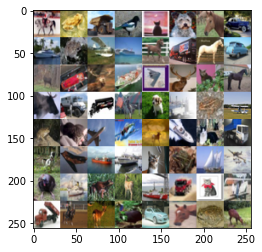

In [6]:
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
for data in train_data.batch(8).take(8):
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1

#plt.figure(figsize=(8, 8))
plt.imshow(output)

In [7]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入前面的資料愈處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [9]:
model_dir = 'lab4-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir)  # 創建儲存權重目錄

FileExistsError: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'lab4-logs/models'

### 影像增強(Image Augmentation)

In [10]:
train_data = tfds.load("cifar10", split=train_split)

In [13]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x

def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x




In [11]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [14]:
# 打散資料集
train_data = train_data.shuffle(train_num)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

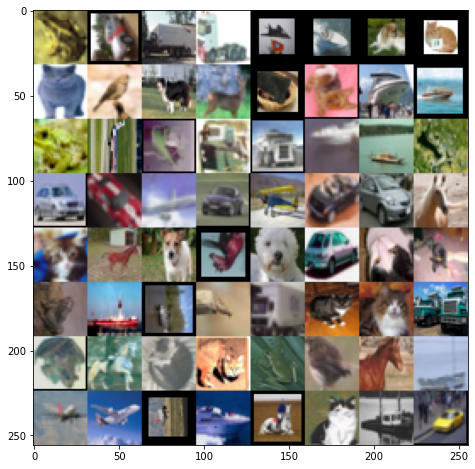

In [15]:
# 由於前面已經將train_data batch size設定為64，所以取一次資料就有64筆
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

In [16]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # 顯示網路架構

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

建立Callback function：

In [17]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [19]:
history_3 = model_3.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 49s 26ms/step - loss: 2.0453 - categorical_accuracy: 0.2304 - val_loss: 1.7158 - val_categorical_accuracy: 0.3546
Epoch 2/100
704/704 [==============================] - 17s 24ms/step - loss: 1.8490 - categorical_accuracy: 0.3164 - val_loss: 1.5915 - val_categorical_accuracy: 0.4116
Epoch 3/100
704/704 [==============================] - 17s 24ms/step - loss: 1.7492 - categorical_accuracy: 0.3575 - val_loss: 1.5189 - val_categorical_accuracy: 0.4588
Epoch 4/100
704/704 [==============================] - 17s 24ms/step - loss: 1.6655 - categorical_accuracy: 0.3968 - val_loss: 1.3804 - val_categorical_accuracy: 0.5054
Epoch 5/100
704/704 [==============================] - 17s 24ms/step - loss: 1.5868 - categorical_accuracy: 0.4266 - val_loss: 1.2260 - val_categorical_accuracy: 0.5624
Epoch 6/100
704/704 [==============================] - 17s 24ms/step - loss: 1.5232 - categorical_accuracy: 0.4545 - val_loss: 1.1523 - val_categorical_acc

704/704 [==============================] - 18s 25ms/step - loss: 0.7687 - categorical_accuracy: 0.7435 - val_loss: 0.6002 - val_categorical_accuracy: 0.8006
Epoch 97/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7755 - categorical_accuracy: 0.7407 - val_loss: 0.5975 - val_categorical_accuracy: 0.8064
Epoch 98/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7599 - categorical_accuracy: 0.7498 - val_loss: 0.6260 - val_categorical_accuracy: 0.7992
Epoch 99/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7667 - categorical_accuracy: 0.7451 - val_loss: 0.6164 - val_categorical_accuracy: 0.7960
Epoch 100/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7701 - categorical_accuracy: 0.7474 - val_loss: 0.6330 - val_categorical_accuracy: 0.7946


驗證在測試集上：

In [21]:
loss, acc = model_3.evaluate(test_data)
print('\nModel Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 8ms/step - loss: 0.6236 - categorical_accuracy: 0.8019

Model Accuracy: 0.8019000291824341%


In [44]:
%reload_ext tensorboard
#%tensorboard --port 9530 --logdir lab4-logs 

In [46]:
%tensorboard --port 9530 --logdir lab4-logs

Reusing TensorBoard on port 9530 (pid 2512), started 0:15:37 ago. (Use '!kill 2512' to kill it.)

In [37]:
history_3.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])